# Chapter 2 - Statistical Language mModeling
통계 언어 모델링

In [1]:
# << context >>
# 1 단어 빈도계산 (1gram, 2gram, 3gram)
# 2 주어진 텍스트 MLE 개발 (Maximum Likelihood Estimation : 최대우도 측정모델)
# 3 MLE 모델의 스무딩 적용 
# 4 MLE의 back-off 매커니즘 개발
# 5 mix and match 를 억디위한 데이터 보간법 적용
# 6 혼잡도(perplexity)를 활용한 언어모델의 평가
# 7 Metropolis-Hastings (기각표본추출 알고리즘- 몬테카를로 시뮬레이션에 적용) 를 언어모델링에 적용
# 8 Gibbs sampling을 적용

<br></br>
## 1 단어빈도 측정
1-gram, 2-gram, 3-gram

### 01 n-Gram token으로 생성하기
1-gram, 2-gram, 3-gram

In [2]:
# 1-gram, 2-gram, 3-gram 으로 token 만들기
from nltk.util import ngrams
from nltk.corpus import alpino

unigrams = ngrams(alpino.words(),1)
bigrams = ngrams(alpino.words(),2)
quadgrams = ngrams(alpino.words(),4)

for i, word in enumerate(quadgrams):
    if i % 15000 == 0: print(word) 

('De', 'verzekeringsmaatschappijen', 'verhelen', 'niet')
('op', 'het', 'Amerikaanse', 'ingrijpen')
('Oogziekenhuis', ',', 'waar', 'de')
('de', 'kopers', 'van', 'de')
('we', 'hier', 'Hollandse', 'lijnrechters')
('defensie', '.', 'Ik', 'heb')
('blank', 'deel', 'uiteenvalt', '.')
('treedt', ',', 'ben', 'ik')
('hij', 'vindt', 'er', 'een')
('bij', 'nadere', 'uitwerking', 'niet')


### 02 우도를 활용한 상위빈도 text 추출하기
Maximum Likelihood Estimation : 최대우도 측정모델

In [3]:
# token 생성
from nltk.corpus import webtext
tokens=[t.lower()    for t in webtext.words('grail.txt')]

In [4]:
# bi-gram 중, 우도비율 상위 10개 목록 출력
from nltk.collocations import BigramCollocationFinder
from nltk.metrics import BigramAssocMeasures
words = BigramCollocationFinder.from_words(tokens)

print('bi-gram   :' ,words.nbest(BigramAssocMeasures.likelihood_ratio, 10))

bi-gram   : [("'", 's'), ('arthur', ':'), ('#', '1'), ("'", 't'), ('villager', '#'), ('#', '2'), (']', '['), ('1', ':'), ('oh', ','), ('black', 'knight')]


<br></br>
## 2 텍스트의 MLE 개발
Multinomial logistic regression : 다항 기호 논리학 회귀

주어진 발생에 대한 확률분포를 포함하는 freqdist를 생성한다

http://www.nltk.org/howto/probability.html

### 01 token 을  freqdist 객체로 변환하기
nltk.FreqDist() : 단어의 빈도 추출

In [5]:
# freqdist 생성하기
text1 = ['no', 'good', 'fish', 'goes', 'anywhere', 'without', 'a', 'porpoise', '!']
text2 = ['no', 'good', 'porpoise', 'likes', 'to', 'fish', 'fish', 'anywhere', '.']

import nltk
fd1 = nltk.FreqDist(text1); fd1

FreqDist({'!': 1,
          'a': 1,
          'anywhere': 1,
          'fish': 1,
          'goes': 1,
          'good': 1,
          'no': 1,
          'porpoise': 1,
          'without': 1})

In [6]:
# text1 과 text2 의 도수빈도를 결합
both = nltk.FreqDist(text1 + text2); both

FreqDist({'!': 1,
          '.': 1,
          'a': 1,
          'anywhere': 2,
          'fish': 3,
          'goes': 1,
          'good': 2,
          'likes': 1,
          'no': 2,
          'porpoise': 2,
          'to': 1,
          'without': 1})

In [7]:
# freqdist 를 pickle로 저장
import pickle
pickled = pickle.dumps(fd1)
fd1 == pickle.loads(pickled)

True

<br></br>
## 3 은닉 마르코프 모델 추정
Hidden Markov Model estimation

$x_0, x_1..$ : 은닉상태 , $y_0, y_1 ..$ : 관찰 가능한 상태

<img src="http://iacs-courses.seas.harvard.edu/courses/am207/blog/hmm.png" align='left' width='600'>

### 01 Hidden Markov Model estimation
HMM추정을 사용해 테스트를 수행

In [8]:
# HMM추정을 사용해 테스트를 수행
# brown 말뭉치의 내용 확인 (단어, 품사)의 tuple로 구성
import nltk
cor = nltk.corpus.brown.tagged_sents(categories='adventure')[:500]
cor

[[('Dan', 'NP'), ('Morgan', 'NP'), ('told', 'VBD'), ('himself', 'PPL'), ('he', 'PPS'), ('would', 'MD'), ('forget', 'VB'), ('Ann', 'NP'), ('Turner', 'NP'), ('.', '.')], [('He', 'PPS'), ('was', 'BEDZ'), ('well', 'RB'), ('rid', 'JJ'), ('of', 'IN'), ('her', 'PPO'), ('.', '.')], ...]

In [9]:
# nltk의 unique_list 내부 살펴보기
# tag 살펴보기
from nltk.util import unique_list
tag_set = unique_list(tag     for sent in cor     for (word,tag) in sent)
print(len(tag_set))
tag_set[::10]

92


['NP', 'IN', 'PPS+MD', 'NNS', 'JJR', 'BED', 'BER', 'HVD*', 'OD', 'HVG']

In [10]:
# sentence 살펴보기 
symbols = unique_list(word    for sent in cor     for (word,tag) in sent)
print(len(symbols)); symbols[::250]

1464


['Dan', 'them', 'possibility', 'wonder', 'cheek', 'careful']

In [11]:
# 히든 마르코프 훈련모듈 활성화 (92개 tag,  1464개 문장)
trainer = nltk.tag.HiddenMarkovModelTrainer(tag_set, symbols)
train_corpus = []
test_corpus = []

# train 90% , test 10% 데이터 생성
for i in range(len(cor)):
    if i % 10:  train_corpus+=[cor[i]]
    else: test_corpus+=[cor[i]]         
print(len(train_corpus))
print(len(test_corpus))

450
50


In [12]:
# 은닉 마르코프 추정법칙 테스트
def train_and_test(est):
    hmm = trainer.train_supervised(train_corpus, estimator=est)
    print('%.2f%%' % (100 * hmm.evaluate(test_corpus)))

train_and_test(None)

22.75%


### 02 최대 우도추정 모델
Maximum Likelihood Estimation

In [13]:
from nltk import MLEProbDist

mle = lambda fd, bins: MLEProbDist(fd)
train_and_test(mle)

# Laplace (= Lidstone with gamma==1)
from nltk import MLEProbDist, LaplaceProbDist
train_and_test(LaplaceProbDist) 

22.75%
66.04%


In [14]:
# Expected Likelihood Estimation (= Lidstone with gamma==0.5)
from nltk import ELEProbDist
train_and_test(ELEProbDist)

73.01%


In [15]:
#Lidstone Estimation, for gamma==0.1, 0.5 and 1 (the later two should be exactly equal to MLE and ELE above)
from nltk import LidstoneProbDist
def lidstone(gamma):
    return lambda fd, bins: LidstoneProbDist(fd, gamma, bins)

print(train_and_test(lidstone(0.1)))
print(train_and_test(lidstone(0.5)))
print(train_and_test(lidstone(1.0)))

82.51%
None
73.01%
None
66.04%
None


### 03 텍스트의 MLE 개발
다중회귀모델 개발

In [ ]:
# 위의 CLASS를 기초로 '최대우도값'을 추청
import nltk
from nltk.probability import *
# train_and_test(mle)
# train_and_test(LaplaceProbDist)
# train_and_test(ELEProbDist)
def lidstone(gamma):
    return lambda fd, bins: LidstoneProbDist(fd, gamma, bins)
# train_and_test(lidstone(0.1))
# train_and_test(lidstone(0.5))
# train_and_test(lidstone(0.1))

<br></br>
## 4 MLE 모델의 Smoothing 적용
알려지지 않은 단어는 확률이 0이므로, 이를 해결시 사용

### 01 Add-one smoothing
가짜 수 (Pseudo Count) 1을 활용하여, 확률이 0이 아닌 값을 덧붙인다

In [2]:
import nltk
corpus = u"<s> hello how are you doing ? Hope you find the book interesting. </s>".split()
vocabulary = set(corpus)
len(vocabulary)

13

In [3]:
## 문장의 bi-gram 말뭉치 수를 count
sentence = u"<s>how are you doing</s>".split()

cfd = nltk.ConditionalFreqDist(nltk.bigrams(corpus))
[cfd[a][b] for (a,b) in nltk.bigrams(sentence)]

[0, 1, 0]

In [4]:
# 문장의 각 단어 count
[cfd[a].N() for (a,b) in nltk.bigrams(sentence)]

[0, 1, 2]

In [5]:
# MLE 확률에 대한 FreqDist
[cfd[a].freq(b) for (a,b) in nltk.bigrams(sentence)]

[0, 1.0, 0.0]

In [6]:
# 각 bi-gram 에 대한 Laplace smoothing 
[1 + cfd[a][b] for (a,b) in nltk.bigrams(sentence)]

[1, 2, 1]

In [7]:
# 단어의 수를 정규화
[len(vocabulary) + cfd[a].N() for (a,b) in nltk.bigrams(sentence)]

[13, 14, 15]

In [8]:
# 각 bi-gram의 Laplace smoothing 확률
[1.0 * (1+cfd[a][b]) / (len(vocabulary)+cfd[a].N()) for (a,b) in nltk.bigrams(sentence)]

[0.07692307692307693, 0.14285714285714285, 0.06666666666666667]

In [9]:
# MLEProbDist는 smoothing 하지 않은 확률분포
cpd_mle = nltk.ConditionalProbDist(cfd, nltk.MLEProbDist, bins=len(vocabulary))
[cpd_mle[a].prob(b) for (a,b) in nltk.bigrams(sentence)] # .prob() 메소트로 MLE 확률값 계산

[0, 1.0, 0.0]

In [10]:
# LaplaceProbDist : smoothing 된 PorbDist 추가 기능
cpd_laplace = nltk.ConditionalProbDist(cfd, nltk.LaplaceProbDist, bins=len(vocabulary))
[cpd_laplace[a].prob(b) for (a,b) in nltk.bigrams(sentence)]

[0.07692307692307693, 0.14285714285714285, 0.06666666666666667]

In [11]:
import inspect
inspect.getfile(nltk.SimpleGoodTuringProbDist)

'/home/markbaum/Python/python36/lib/python3.6/site-packages/nltk/probability.py'

In [14]:
# 단어의 빈도 구하기
freq_corpus = nltk.FreqDist(corpus)
freq_corpus

FreqDist({'</s>': 1,
          '<s>': 1,
          '?': 1,
          'Hope': 1,
          'are': 1,
          'book': 1,
          'doing': 1,
          'find': 1,
          'hello': 1,
          'how': 1,
          'interesting.': 1,
          'the': 1,
          'you': 2})

In [15]:
# SGT 모형생성
sgt_pd=nltk.SimpleGoodTuringProbDist(freq_corpus)
sgt_pd.discount()

0.8571428571428571

In [16]:
[sgt_pd.prob(v) for v in sentence]

[0.8571428571428571,
 0.008814431021059511,
 0.03708397060442877,
 0.8571428571428571]

In [17]:
# SGT 결과
[sgt_pd.smoothedNr(v+1) for v in range(10)]

[12.0,
 1.0,
 0.23373268044331344,
 0.08333333333333333,
 0.03744553081485653,
 0.019477723370276128,
 0.011208215258425342,
 0.00694444444444445,
 0.004552580492268005,
 0.0031204609012380384]

In [18]:
import pandas as pd
plot_sgt = pd.DataFrame([sgt_pd.smoothedNr(v+1) for v in range(10)])
plot_sgt

,0
0,12.000000
1,1.000000
2,0.233733
3,0.083333
4,0.037446
5,0.019478
6,0.011208
7,0.006944
8,0.004553
9,0.003120


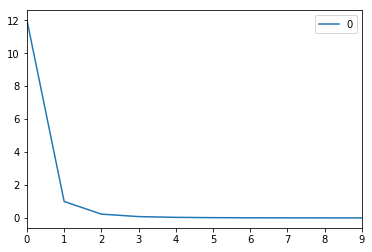

In [22]:
%matplotlib inline
plot_sgt.plot(kind='line')

### 02 Good Turing
보이지 않는 객체의 확룰을 예측

In [ ]:
# nltk 의 simple Good Turing 
gt = lambda fd, bins: SimpleGoodTuringProbDist(fd, bins=1e5)
train_and_test(gt)

In [ ]:
# Bill Gale and Geoffrey Sampson have presented Simple Good Turing:

# 한쌍의 (pi, qi)이 주어진경우, pi 는 빈도를, qi는 빈도의 빈도를 의미한다
# 오차제곰을 최소로 하는 결과를 위해. E(p) 와 E(q) 즉 pi와 qi의 평균을 사용한다
# - slope, b = sigma ((pi-E(p)(qi-E(q))) / sigma ((pi-E(p))(pi-E(p)))
# - intercept: a = E(q) - b.E(p)
class SimpleGoodTuringProbDist(ProbDistI):
    SUM_TO_ONE = False
    
    # param freqdist는 확률분포가 추정되는 빈도의 수
    # Param bins은 가능한 샘플의 수를 추정시 사용
    def __init__(self, freqdist, bins=None):
        assert bins is None or bins > freqdist.B(),\
        'bins parameter must not be less than %d=freqdist.B()+1' %(freqdist.B()+1)
        if bins is None:
            bins = freqdist.B() + 1
            self._freqdist = freqdist
            self._bins = bins
            r, nr = self._r_Nr()
            self.find_best_fit(r, nr)
            self._switch(r, nr)
            self._renormalize(r, nr)

In [ ]:
    def _r_Nr_non_zero(self):
        r_Nr = self._freqdist.r_Nr()
        del r_Nr[0]
        return r_Nr

    # Nr(r)>0 인 2개목록 (r,Nr)에서 도수분포를 나눈다
    def _r_Nr(self): 
        nonzero = self._r_Nr_non_zero()
        if not nonzero: 
            return [], []
        return zip(*sorted(nonzero.items()))    

In [ ]:
    # self._slope, self._intercept 매개변수 조정을 위한, 선형회귀 분석을 시행한다
    # (log 공간에서 작업을 함으로써, 부동소숫점 underflow가 발생하지 않도록 한다)
    # 높은 샘플빈고를 갖는 경우, Nr = 1을 따라 수평이 된다
    # Log 공간에서의 연선을 위해, 주변 0값으로 양의 Nr값을 평균화 한다 (Church and Gale, 1991)
    def find_best_fit(self, r, nr):
        if not r or not nr: #  r 또는 nr이 비었는지 확인
            return
        
        zr = []
        for j in range(len(r)):
            i = (r[j-1] if j > 0 else 0)
            k = (2 * r[j] - i if j == len(r) - 1 else r[j+1])
            zr_ = 2.0 * nr[j] / (k - i)
            zr.append(zr_)
            log_r = [math.log(i) for i in r]
            log_zr = [math.log(i) for i in zr]
            xy_cov = x_var = 0.0
            x_mean = 1.0 * sum(log_r) / len(log_r)
            y_mean = 1.0 * sum(log_zr) / len(log_zr)
            for (x, y) in zip(log_r, log_zr):
                xy_cov += (x - x_mean) * (y - y_mean)
                x_var += (x - x_mean)**2
                
        self._slope = (xy_cov / x_var if x_var != 0 else 0.0)
        if self._slope >= -1:
            warnings.warn('SimpleGoodTuring did not find a proper best fit '
                          'line for smoothing probabilities of occurrences. '
                          'The probability estimates are likely to be '
                          'unreliable.')
        
        self._intercept = y_mean - self._slope * x_mean

In [ ]:
        # E[Nr]을 추정시 Nr에서 Sr로 전환해야 하는 r frontier를 계산한다
        def _switch(self, r, nr):
            for i, r_ in enumerate(r):
                # r이 끝에 있거나, 간격이 있는 경우
                if len(r) == i + 1 or r[i+1] != r_ + 1:
                    self._switch_at = r_
                    break
                Sr = self.smoothedNr
                smooth_r_star = (r_ + 1) * Sr(r_+1) / Sr(r_)
                unsmooth_r_star = 1.0 * (r_ + 1) * nr[i+1] / nr[i]

                std = math.sqrt(self._variance(r_, nr[i], nr[i+1]))
                if abs(unsmooth_r_star-smooth_r_star) <= 1.96 * std:
                    self._switch_at = r_
                    break

In [ ]:
        def _variance(self, r, nr, nr_1):
            r = float(r)
            nr = float(nr)
            nr_1 = float(nr_1)
            return (r + 1.0)**2 * (nr_1 / nr**2) * (1.0 + nr_1 / nr)

        def _renormalize(self, r, nr):
            prob_cov = 0.0
            for r_, nr_ in zip(r, nr):
                prob_cov += nr_ * self._prob_measure(r_)
            if prob_cov:
                self._renormal = (1 - self._prob_measure(0)) / prob_cov

In [ ]:
        # count r 로 샘플의 수를 반환한다
        # Nr = a*r^b (적절한 쌍곡선형 상관을 제공하기 위해 b < -1) 
        # 방정식의 대수 형테애 대한 간단한 회귀 기법으로, a와 b를 추정한다
        # log Nr = a + b*log(r)
        def smoothedNr(self, r):
            return math.exp(self._intercept + self._slope * math.log(r))

        def prob(self, sample): # 샘플의 확률을 반환한다
            count = self._freqdist[sample]
            p = self._prob_measure(count)
            if count == 0:
                if self._bins == self._freqdist.B(): p = 0.0
                else: p = p / (1.0 * self._bins - self._freqdist.B())
            else: p = p * self._renormal
            return p

In [ ]:
        def _prob_measure(self, count):
            if count == 0 and self._freqdist.N() == 0 : 
                return 1.0
            elif count == 0 and self._freqdist.N() != 0:
                return 1.0 * self._freqdist.Nr(1) / self._freqdist.N()
            if self._switch_at > count:
                Er_1 = 1.0 * self._freqdist.Nr(count+1)
                Er = 1.0 * self._freqdist.Nr(count)
            else:
                Er_1 = self.smoothedNr(count+1)
                Er = self.smoothedNr(count)
            r_star = (count + 1) * Er_1 / Er
            return r_star / self._freqdist.N()

In [ ]:
        # 확률의 총합이 1인지를 통해서 (prob_sum != 1.0) 확인
        def check(self):
            prob_sum = 0.0
            for i in range(0, len(self._Nr)):
                prob_sum += self._Nr[i] * self._prob_measure(i) / self._renormal
            print("Probability Sum:", prob_sum)

In [ ]:
        # 보이는 이벤트에서 보이지 않는 이벤트로 확률을 전송
        def discount(self):
            return 1.0 * self.smoothedNr(1) / self._freqdist.N()
        def max(self):
            return self._freqdist.max()
        def samples(self):
            return self._freqdist.keys()
        def freqdist(self):
            return self._freqdist
        def __repr__(self): # ProbDist 의 문자열 표현을 얻는다
            return '<SimpleGoodTuringProbDist based on %d samples>'\
            % self._freqdist.N()

### 03 크네저 네이 추정
Kneser Ney estimation

In [ ]:
sent = " Hello , please read the book thoroughly .\
 If you have any queries , then don't hesitate to ask.\
 There is no shortcut to success ."

In [ ]:
import nltk
for x,y,z in nltk.trigrams(sent):
    pass
    #print(x[0],y[0],z[0])
    #print(x[1],y[1],z[1])  # 여기서 오류가 발생

In [ ]:
# corpus = [[((x[0],y[0],z[0]),(x[1],y[1],z[1])) for x, y, z in nltk.trigrams(sent)] 
#           for sent in corpus[:100]]
# tag_set = unique_list(tag for sent in corpus for (word,tag) in sent)
# print(len(tag_set))
# symbols = unique_list(word for sent in corpus for (word,tag) in sent)
# print(len(symbols))
# trainer = nltk.tag.HiddenMarkovModelTrainer(tag_set, symbols)
# train_corpus = []
# test_corpus = []
# for i in range(len(corpus)):
#     if i % 10: train_corpus += [corpus[i]]
#     else:      test_corpus += [corpus[i]]
# kn = lambda fd, bins: KneserNeyProbDist(fd)
# train_and_test(kn)

### 04 위튼 벨 추정
Witten Bell estimation

In [ ]:
train_and_test(WittenBellProbDist)

<br></br>
## 5 MLE의 back-off 매커니즘 개발
Develop a back-off mechanism for MLE

http://blog.naver.com/PostView.nhn?blogId=hot1455&logNo=60128729107

In [ ]:
# Train시 n-gram이 n번이상 보일경우, 이전정보가 주어지면 token의 조건부 확률은 n-gram의 MLE에 비례한다.
# 그렇지 않으면 조건부 확률은 (n-1)gram의 back-off 조건부 확률(이전 정보가 주어진 token의 조건부 확률)과 동일하다

In [ ]:
# param word: 확률계산할 단어
# type word: str
# param context: 단어를 포함한 문장
# type context: list(str)
def prob(self, word, context): # Katz back-off 모델
    context = tuple(context)
    if(context+(word,) in self._ngrams) or (self._n == 1):
        return self[context].prob(word)
    else:
        return self._alpha(context) * self._backoff.prob(word,context[1:])

<br></br>
## 6  Mix and Match를 얻기위한 데이터 보간법
uni-gram을 수행후 bi-gram을 수행함으로써 둘의 확률을 결합하는 보간모델의 개발이 가능하다

<br></br>
## 7 혼잡도를 통한 언어 모델의 평가
perplexity(text) : 텍스트의 혼잡도를 평가한다 (2**cross entropy로 측정)

텍스트를 예측하는데 유용

In [ ]:
"""
Calculates the perplexity of the given text.
This is simply 2 ** cross-entropy for the text.
:param text: words to calculate perplexity of
:type text: list(str)
"""
def perplexity(self, text):
    return pow(2.0, self.entropy(text))

<br></br>
## 8 모델링 언어에서 메트로폴리스 헤어스팅스 적용
마르코프 모델에서 사후분포처리를 수행하기 위해 Metropolis-Hastings sampler를 사용한다

<br></br>
## 9 Gibbs sampling 을 언어처리시 적용
Gibbs sampling

In [ ]:
# N번 시행과 Z번 성공시 Bernoulli 가능성(likelihood)
def bern(theta,z,N):
    return np.clip(theta**z*(1-theta)**(N-z),0,1)
# N번 시행과 Z번 성공시 Bernoulli 가능성(likelihood)
def bern2(theta1,theta2,z1,z2,N1,N2):
    return bern(theta1,z1,N1)*bern(theta2,z2,N2)

In [ ]:
def make_thetas(xmin,xmax,n):
    xs=np.linspace(xmin,xmax,n)
    widths=(xs[1:]-xs[:-1])/2.0
    thetas=xs[:-1]+widths
    return hetas

In [ ]:
def make_plots(X,Y,prior,likelihood,posterior,projection=None):
    fig,ax=plt.subplots(1,3,subplot_kw=dict(projection=projection,aspect='equal'),figsize=(12,3))
    if projection=='3d':
        ax[0].plot_surface(X,Y,prior,alpha=0.3,cmap=plt.cm.jet)
        ax[1].plot_surface(X,Y,likelihood,alpha=0.3,cmap=plt.cm.jet)
        ax[2].plot_surface(X,Y,posterior,alpha=0.3,cmap=plt.cm.jet)
    else:
        ax[0].contour(X,Y,prior)
        ax[1].contour(X,Y,likelihood)
        ax[2].contour(X,Y,posterior)
        ax[0].set_title('Prior')
        ax[1].set_title('Likelihood')
        ax[2].set_title('Posteior')
    plt.tight_layout()
    thetas1=make_thetas(0,1,101)
    thetas2=make_thetas(0,1,101)
    X,Y=np.meshgrid(thetas1,thetas2)

In [ ]:
# # Metropolice 시행
# import numpy as np
# a = 2
# b = 3
# z1 = 11
# N1 = 14
# z2 = 7
# N2 = 14
# prior = lambda theta1,theta2:stats.beta(a,b).pdf(theta1)*stats.beta(a,b).pdf(theta2)
# lik = partial(bern2,z1=z1,z2=z2,N1=N1,N2=N2)
# target = lambda theta1,theta2:prior(theta1,theta2)*lik(theta1,theta2)
# theta = np.array([0.5,0.5])
# niters = 10000
# burnin = 500
# sigma = np.diag([0.2,0.2])
# thetas = np.zeros((niters-burnin,2),np.float)
# for i in range(niters):
#     new_theta = stats.multivariate_normal(theta,sigma).rvs()
#     p = min(target(*new_theta)/target(*theta),1)
#     if np.random.rand() < p:
#         theta = new_theta
#     if i >= burnin:
#         thetas[i-burnin] = theta
#         kde = stats.gaussian_kde(thetas.T)
# XY = np.vstack([X.ravel(),Y.ravel()])
# posterior_metroplis = kde(XY).reshape(X.shape)
# make_plots(X,Y,prior(X,Y),lik(X,Y),posterior_metroplis)
# make_plots(X,Y,prior(X,Y),lik(X,Y),posterior_metroplis,projection='3d')

In [ ]:
# Gibbs 수행
# a = 2
# b = 3
# z1 = 11
# N1 = 14
# z2 = 7
# N2 = 14
# prior = lambda theta1,theta2:stats.beta(a,b).pdf(theta1)*stats.
# beta(a,b).pdf(theta2)
# lik = partial(bern2,z1=z1,z2=z2,N1=N1,N2=N2)
# target = lambdatheta1,theta2:prior(theta1,theta2)*lik(theta1,theta2)
# theta = np.array([0.5,0.5])
# niters = 10000
# burnin = 500
# sigma = np.diag([0.2,0.2])
# thetas = np.zeros((niters-burnin,2),np.float)
# for i in range(niters):
#     theta = [stats.beta(a+z1,b+N1-z1).rvs(),theta[1]]
#     theta = [theta[0],stats.beta(a+z2,b+N2-z2).rvs()]
# if i>= burnin:
#     thetas[i-burnin] = theta
#     kde = stats.gaussian_kde(thetas.T)
#     XY = np.vstack([X.ravel(),Y.ravel()])
#     posterior_gibbs = kde(XY).reshape(X.shape)
# make_plots(X,Y,prior(X,Y),lik(X,Y),posterior_gibbs)
# make_plots(X,Y,prior(X,Y),lik(X,Y),posterior_gibbs,projection='3d')